In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch
from digits_recognition.evaluation_inference import load_model, infer_labels

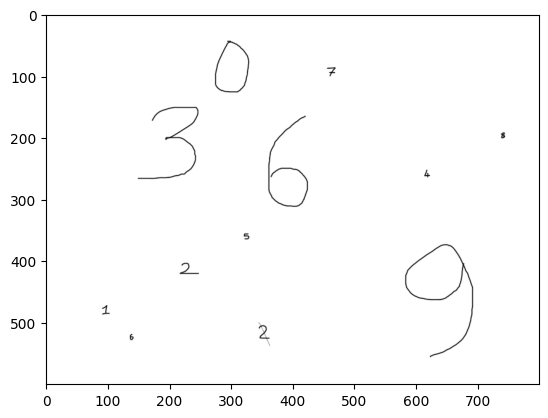

In [2]:
image = cv2.imread('test2.png')
plt.imshow(image)

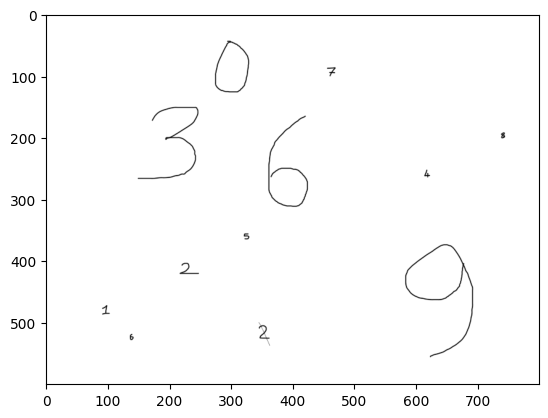

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

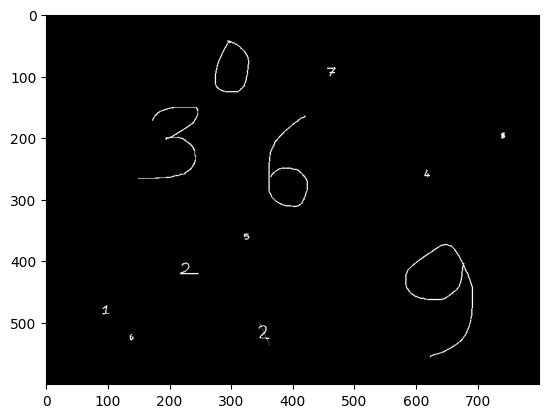

In [4]:
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')

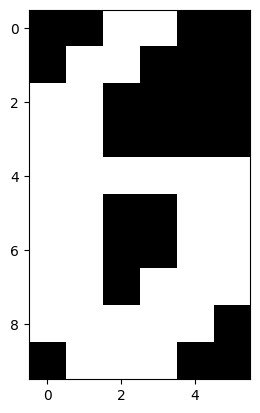

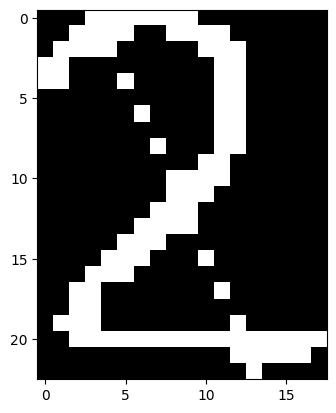

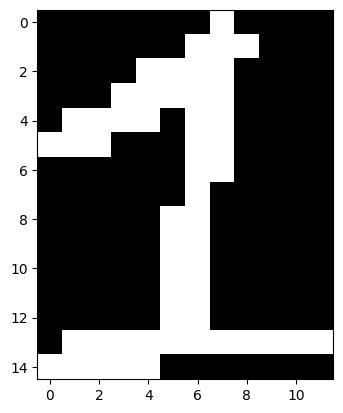

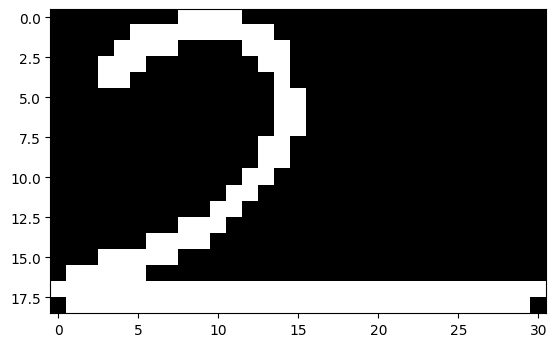

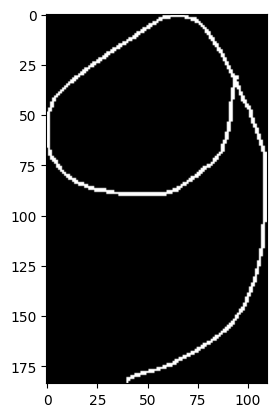

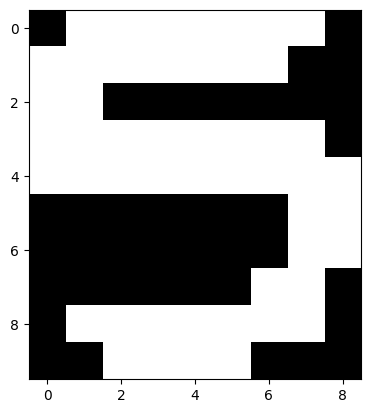

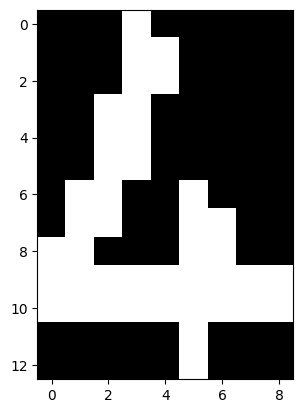

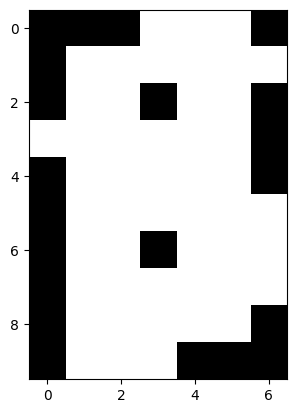

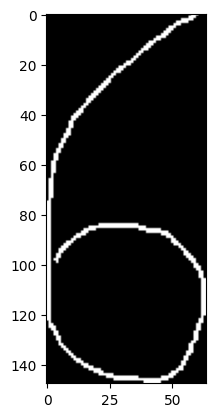

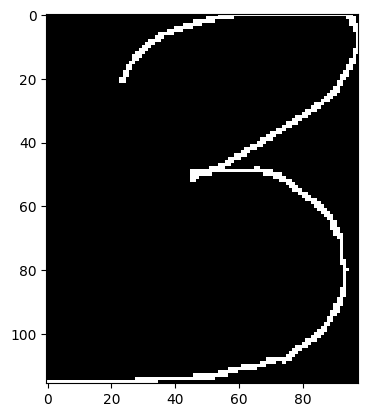

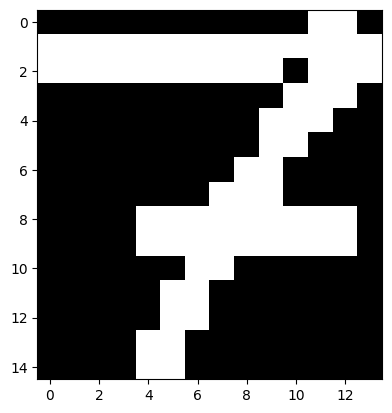

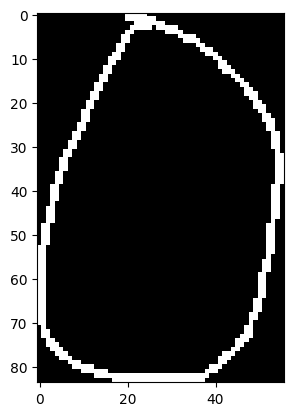

In [5]:
min_area = 10

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(len(contours))
digit_contours = [c for c in contours if cv2.contourArea(c) > min_area]
digits = []

for contour in digit_contours:
    x, y, w, h = cv2.boundingRect(contour)
    digit = binary[y:y+h, x:x+w]
    digits.append(digit)
    plt.figure()  # Create a new figure for each digit
    plt.imshow(digit, cmap='gray')

plt.show()

In [6]:
def pad_digit(digit_image):
    h, w = digit_image.shape
    max_dim = max(h, w)

    final_dim = 28

    if max_dim > final_dim:
        if max_dim == h:
            new_h = final_dim
            new_w = int((final_dim / h) * w)
        else:
            new_w = final_dim
            new_h = int((final_dim / w) * h)
   
        digit_image = cv2.resize(digit_image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        w = new_w
        h = new_h

    top_pad = (final_dim - h) // 2
    bottom_pad = final_dim - h - top_pad
    left_pad = (final_dim - w) // 2
    right_pad = final_dim - w - left_pad
    
    square_digit = np.pad(
        digit_image,
        (
            (top_pad, bottom_pad),
            (left_pad, right_pad)
        ),
        mode='constant',
        constant_values=0  # Black padding
    )
    
    return square_digit

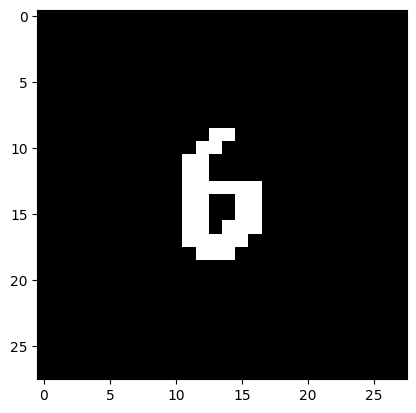

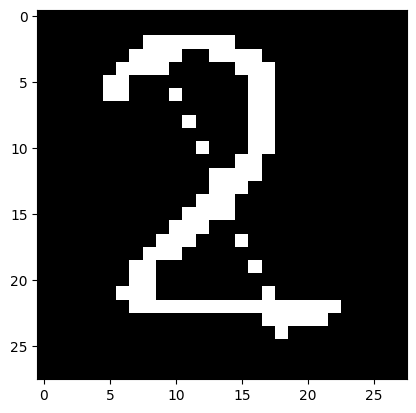

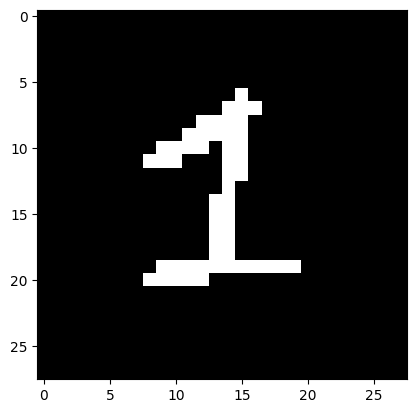

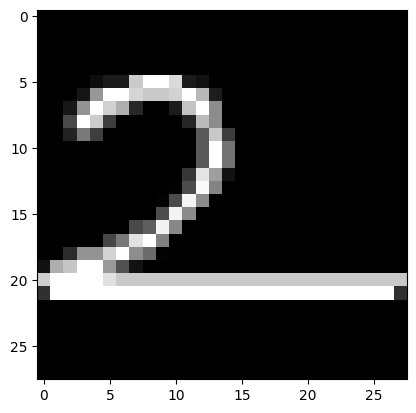

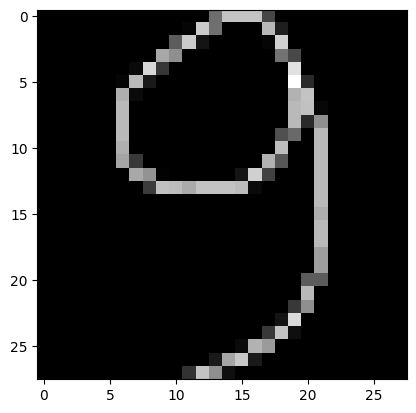

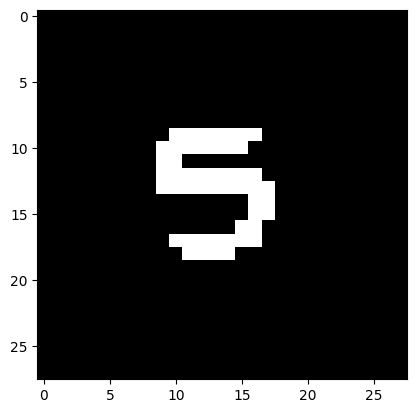

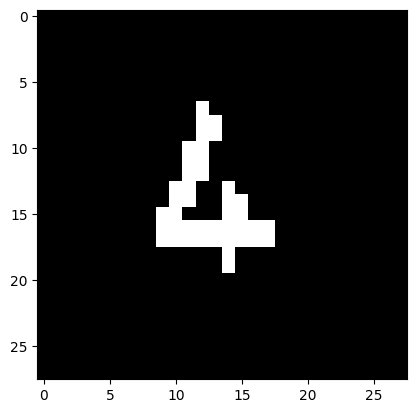

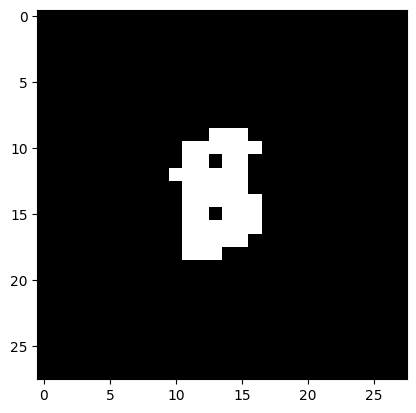

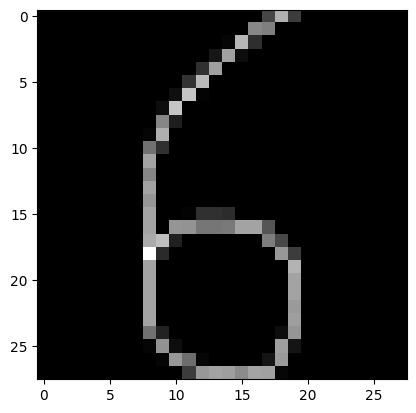

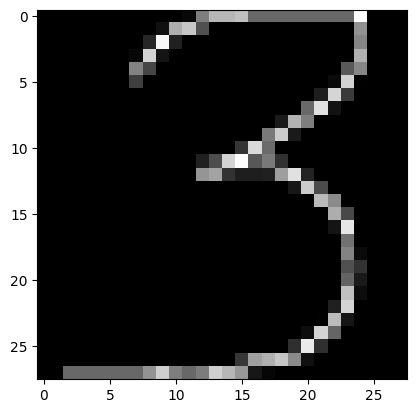

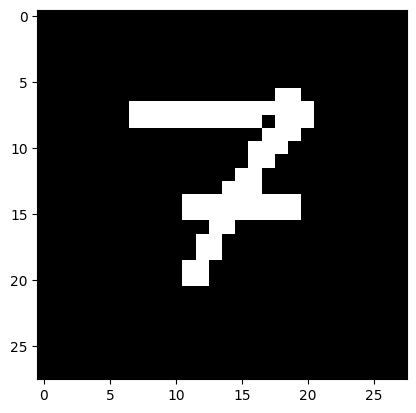

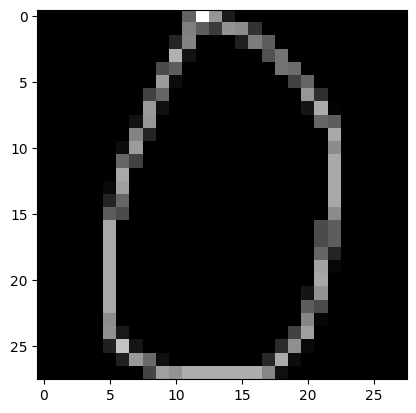

In [7]:
digits_resized = []

for digit in digits:
    digit_resized = pad_digit(digit)
    digits_resized.append(digit_resized)
    plt.figure()  # Create a new figure for each digit
    plt.imshow(digit_resized, cmap='gray')
    
plt.show()

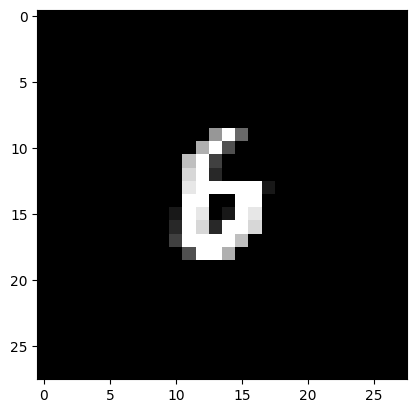

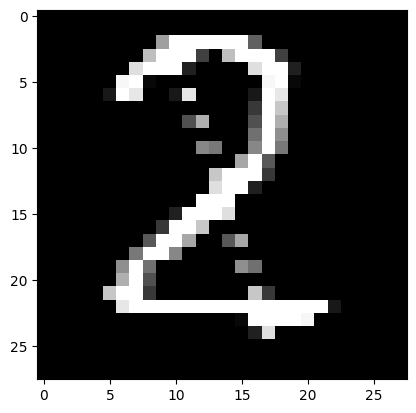

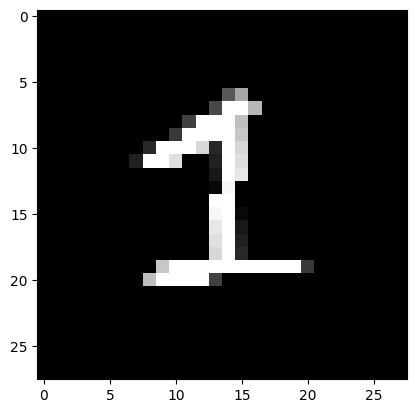

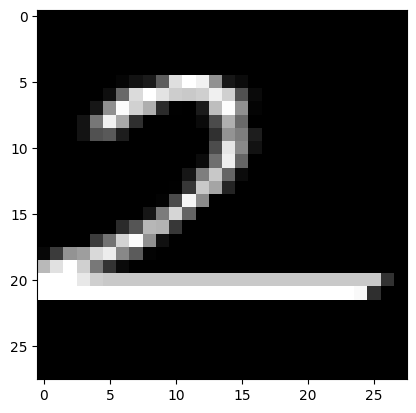

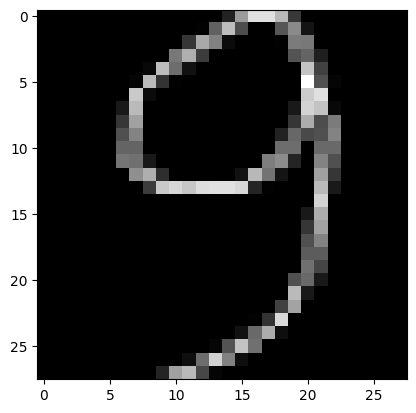

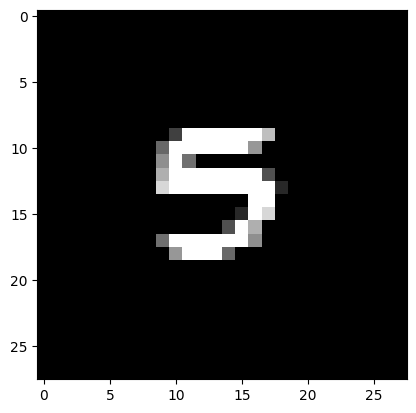

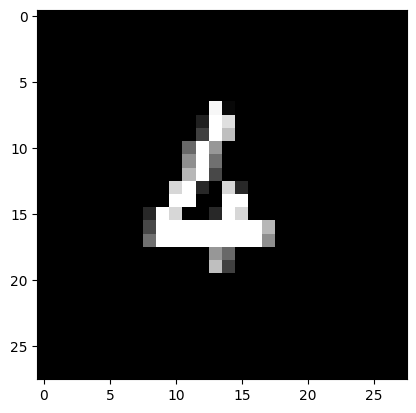

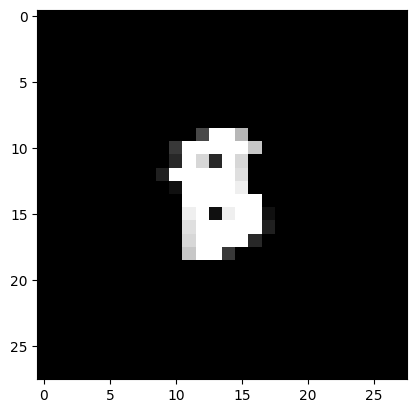

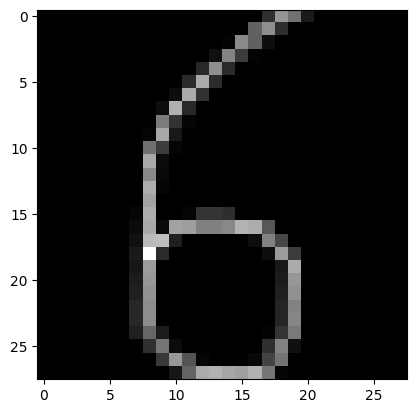

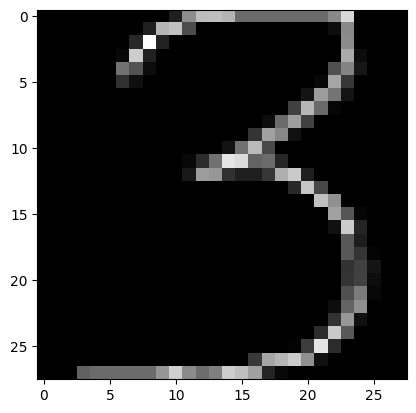

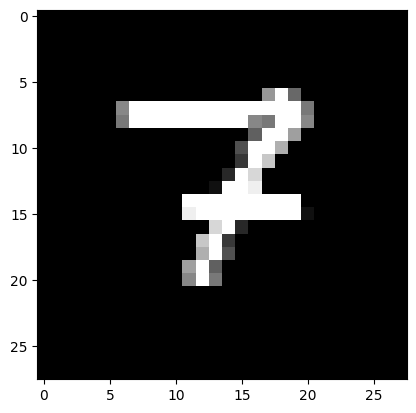

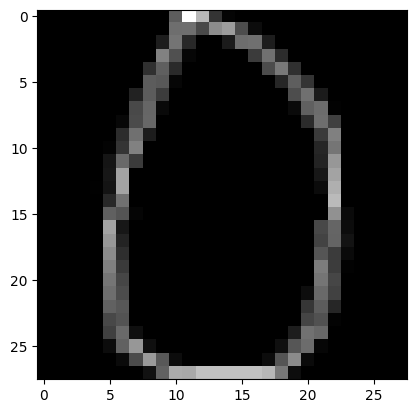

In [8]:
digits_deskewed = []

for digit in digits_resized:
    moments = cv2.moments(digit)
    if moments["mu02"] != 0:
        skew = moments["mu11"] / moments["mu02"]
        M = np.float32([[1, skew, -0.5 * 28 * skew], [0, 1, 0]])
        digit_deskewed = cv2.warpAffine(digit, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

        digits_deskewed.append(digit_deskewed)
        plt.figure()
        plt.imshow(digit_deskewed, cmap='gray')
    
plt.show()

In [9]:
model, device = load_model('../models/digit_classifier.pth')

In [10]:
images = np.array(digits_deskewed, dtype=np.float32)
images = np.expand_dims(images, axis=1) # add back the channel dimension
images.shape

(12, 1, 28, 28)

In [11]:
images = torch.tensor(images)
images.shape

torch.Size([12, 1, 28, 28])

In [12]:
predictions = infer_labels(model, device, images)

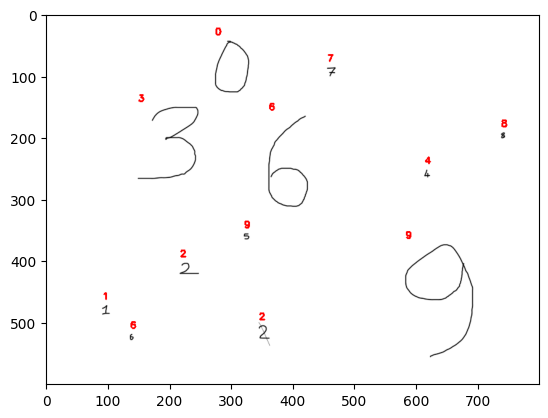

In [13]:
annotated_image = image.copy()

for idx, contour in enumerate(digit_contours):
    x, y, w, h = cv2.boundingRect(contour)

    label = f"{predictions[idx]}"
    cv2.putText(annotated_image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.imshow(annotated_image)

In [14]:
def annotate_digits_in_image(image):
    image = cv2.imread('test.png')

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    min_area = 10

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digit_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    coords = []
    digits_deskewed = []

    for contour in digit_contours:
        x, y, w, h = cv2.boundingRect(contour)
        digit = binary[y:y+h, x:x+w]
        digit_resized = pad_digit(digit)
        moments = cv2.moments(digit)
        if moments["mu02"] != 0:
            skew = moments["mu11"] / moments["mu02"]
            M = np.float32([[1, skew, -0.5 * 28 * skew], [0, 1, 0]])
            digit_deskewed = cv2.warpAffine(digit_resized, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

            digits_deskewed.append(digit_deskewed)
        
        coords.append((x, y))

    model, device = load_model('../models/digit_classifier.pth')
    digit_array = np.array(digits_deskewed, dtype=np.float32)
    digit_array = np.expand_dims(digit_array, axis=1) # add back the channel dimension
    digits_tensor = torch.tensor(digit_array)
    predictions = infer_labels(model, device, digits_tensor)

    annotated_image = image.copy()

    for idx, (x, y) in enumerate(coords):
        label = f"{predictions[idx]}"
        cv2.putText(annotated_image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return predictions,annotated_image

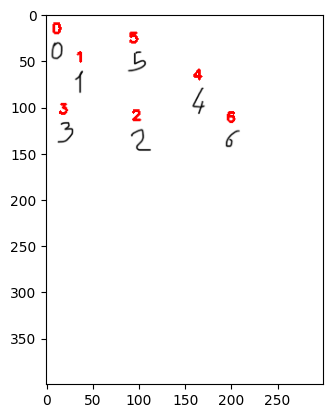

In [15]:
predictions, annotated_image = annotate_digits_in_image(image)
plt.imshow(annotated_image)